# Import and setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import few

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import SchwarzEccFlux, KerrEccEqFlux
# from few.amplitude.romannet import RomanAmplitude
from few.amplitude.ampinterp2d import AmpInterpKerrEccEq
from few.summation.interpolatedmodesum import InterpolatedModeSum, CubicSplineInterpolant


from few.utils.ylm import GetYlms
from few.utils.modeselector import ModeSelector
from few.summation.interpolatedmodesum import CubicSplineInterpolant
from few import get_file_manager

from few.waveform import (
    FastKerrEccentricEquatorialFlux,
    FastSchwarzschildEccentricFlux, 
    SlowSchwarzschildEccentricFlux, 
    Pn5AAKWaveform,
    GenerateEMRIWaveform
)

from few.utils.geodesic import get_fundamental_frequencies

import GWfuncs
import gc
import pickle
import os
import cupy as cp
import multiprocessing as mp
from multiprocessing import Queue, Process
from functools import partial
from SNR_tutorial_utils import LISA_Noise
from lisatools.sensitivity import *

from few.utils.constants import YRSID_SI, Gpc, MRSUN_SI



# import pandas as pd
# tune few configuration
cfg_set = few.get_config_setter(reset=True)
cfg_set.set_log_level("info");

# Generating waveform via FEW func

In [5]:
# Parameters
m1 = 1e6 #M
m2 = 1e1 #mu
a = 0.5
p0 = 9.5
e0 = 0.2
theta = np.pi / 3.0 
phi = np.pi / 4.0  
dt = 10.0
T = 1
xI0 = 1.0 
dist = 1 #Gpc
#in the paper xI0 = 0.866, but that would be non-equatorial case

use_gpu = True 
func = "KerrEccentricEquatorial"


In [21]:
# keyword arguments for inspiral generator 
inspiral_kwargs={
        "func": 'KerrEccEqFlux',
        "DENSE_STEPPING": 0, #change to 1/True for uniform sampling
        "include_minus_m": False, 
        "use_gpu" : use_gpu,
        "force_backend": "cuda12x"  # Force GPU
}

# keyword arguments for inspiral generator 
amplitude_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "use_gpu" : use_gpu
}

# keyword arguments for Ylm generator (GetYlms)
Ylm_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    # "assume_positive_m": True  # if we assume positive m, it will generate negative m for all m>0
}

# keyword arguments for summation generator (InterpolatedModeSum)
sum_kwargs = {
    "force_backend": "cuda12x",  # Force GPU
    "pad_output": False,
    # "use_gpu" : use_gpu
}

# Kerr eccentric flux
waveform_gen = FastKerrEccentricEquatorialFlux(
    inspiral_kwargs=inspiral_kwargs,
    amplitude_kwargs=amplitude_kwargs,
    Ylm_kwargs=Ylm_kwargs,
    sum_kwargs=sum_kwargs,
    use_gpu=use_gpu,
)


In [26]:
%%time
h_true = waveform_gen(m1, m2, a, p0, e0, xI0, theta, phi, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

CPU times: user 145 ms, sys: 6.78 ms, total: 152 ms
Wall time: 149 ms


In [40]:
N = int(len(h_true)) 
print(N)
gwf = GWfuncs.GravWaveAnalysis(N=N,dt=dt)

3155815


In [67]:
factor = gwf.dist_factor(dist, m2)


# Generating amps, traj., etc.

Since there were problems with the upsampling process, keeping it False first

In [42]:
traj = EMRIInspiral(func=KerrEccEqFlux, force_backend="cuda12x", use_gpu=use_gpu) #theres npoints flag here
amp = AmpInterpKerrEccEq(force_backend="cuda12x") # default lmax=10, nmax=55
interpolate_mode_sum = InterpolatedModeSum(force_backend="cuda12x")
ylm_gen = GetYlms(include_minus_m=False, force_backend="cuda12x")

In [43]:
%%time 
# Calc trajectory
(t, p, e, x, Phi_phi, Phi_theta, Phi_r) = traj(m1, m2, a, p0, e0, xI0, T=T, dt=dt) #False

# Get amplitudes along trajectory
teuk_modes = amp(a, p, e, x)

# Get Ylms
ylms = ylm_gen(amp.unique_l, amp.unique_m, theta, phi).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 22.1 ms, sys: 5.76 ms, total: 27.9 ms
Wall time: 24.9 ms


# Generating frequencies

In [57]:
OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x) #TODO: do change the cpu-gpu intermix here

In [58]:
l_cpu = amp.l_arr.get()
m_cpu = amp.m_arr.get()
n_cpu = amp.n_arr.get()

In [59]:
gw_frequencies_per_mode = []


for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi + n * OmegaR
    
    gw_frequencies_per_mode.append(f_gw)

In [60]:
gw_phase_per_mode = []
for idx in range(len(mode_labels)):
    # l = amp.l_arr[idx]
    # m = amp.m_arr[idx] 
    # n = amp.n_arr[idx]
    
    l = l_cpu[idx]
    m = m_cpu[idx] 
    n = n_cpu[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi + n * Phi_r
    
    gw_phase_per_mode.append(phi_mode)

# Selecting modes (purely by power)

In [47]:
# Get mode labels
mode_labels = [f"({l},{m},{n})" for l,m,n in zip(amp.l_arr, amp.m_arr, amp.n_arr)]

In [44]:
m0mask = amp.m_arr_no_mask != 0
# Calculate power for all modes
total_power = gwf.calc_power(teuk_modes, ylms, m0mask)

In [45]:
total_power_cpu = total_power.get()

In [50]:
# Bar plot of modes vs approx inner product for top M modes 
M_mode = 10
mp = list(zip(mode_labels, total_power_cpu)) 
# Sort by power and pick top M modes
mp_sorted = sorted(mp, key=lambda x: x[1], reverse=True)[:M_mode]
mp_modes = [x[0] for x in mp_sorted]
mp_power = [x[1] for x in mp_sorted]

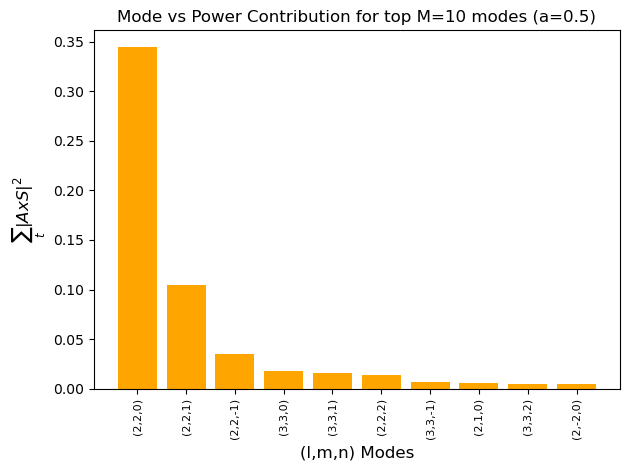

In [51]:
plt.bar(range(len(mp_power)), mp_power, color='orange')
plt.xticks(range(len(mp_modes)), mp_modes, rotation=90, fontsize=8)
plt.xlabel('(l,m,n) Modes', fontsize=12)
plt.ylabel(r'$\sum_{t} |AxS|^2$', fontsize=12)
plt.title('Mode vs Power Contribution for top M={} modes (a={})'.format(M_mode,a), fontsize=12)
plt.yscale('linear')
plt.tight_layout()
plt.show()

In [55]:
# Pick modes based on top M power contributions
top_indices = [mode_labels.index(mode) for mode in mp_modes]
print("Top mode indices:", top_indices)


Top mode indices: [1165, 1166, 1164, 1498, 1499, 1167, 1497, 1054, 1500, 7159]


# $\rho$

In [37]:
def rhostat(h):
    # optimal SNR 
    # assuming the h is still in time-domain

    # TODO: do convert to be compatible with gpu arrays
    hf = gwf.freq_wave(h).get()
    calc_inner = gwf.inner(hf,hf)
    return np.sqrt(calc_inner)

In [39]:
rhostat(h_temp)

np.float64(9.766156325848817)

In [64]:
def calc_inner(idx_i, idx_j, teuk_modes, amp, freqs, phases, delta_T, factor):
    # Obtain the lmn-s
    l_i = amp.l_arr[idx_i]
    m_i = amp.m_arr[idx_i]
    n_i = amp.n_arr[idx_i]

    l_j = amp.l_arr[idx_j]
    m_j = amp.m_arr[idx_j]
    n_j = amp.n_arr[idx_j]

    # Get Teukolsky modes
    # Check if negative m 
    if m_i >= 0:
        A_i = teuk_modes[:, idx_i]

    elif m_i < 0:
        pos_m_mask_i = (amp.l_arr == l_i) & (amp.m_arr == -m_i) & (amp.n_arr == n_i)
        pos_m_idx_i = np.where(pos_m_mask_i)[0]
        A_i_pos = teuk_modes[:, pos_m_idx_i]
        A_i = (-1)**l_i * np.conj(A_i_pos)

    if m_j >= 0:
        A_j = teuk_modes[:, idx_j]
        
    elif m_j < 0:
        pos_m_mask_j = (amp.l_arr == l_j) & (amp.m_arr == -m_j) & (amp.n_arr == n_j)
        pos_m_idx_j = np.where(pos_m_mask_j)[0]
        A_j_pos = teuk_modes[:, pos_m_idx_j]
        A_j = (-1)**l_j * np.conj(A_j_pos)

    # Get sensitivity for each mode 
    Sn_i = get_sensitivity(freqs[idx_i], sens_fn=LISASens, return_type="PSD")
    Sn_j = get_sensitivity(freqs[idx_j], sens_fn=LISASens, return_type="PSD")

    # Get noise-weighted amplitudes
    bar_A_i = A_i.get() / np.sqrt(Sn_i)
    bar_A_j = A_j.get() / np.sqrt(Sn_j)

    # Get phase mask
    phase_mask = np.abs(phases[idx_i] - phases[idx_j]) < 1.0 

    # Calculate product
    prod = np.conj(bar_A_i[phase_mask]) * bar_A_j[phase_mask]

    # Calculate full inner product
    innerprod = np.sum(np.real(prod)) * delta_T * 1/(factor**2)

    return innerprod

In [65]:
def rhostat_modes(mode_indices, teuk_modes, amp, freqs, phases, delta_T, factor):
    rho_modes = []
    
    for mode_idx in mode_indices:
        inner_product = calc_inner(mode_idx, mode_idx, teuk_modes, amp, freqs, phases, delta_T, factor)
        
        rho_m = np.sqrt(inner_product)
        rho_modes.append(rho_m)
    
    return np.array(rho_modes)

In [68]:
rhostat_modes(top_indices, teuk_modes, amp, gw_frequencies_per_mode, gw_phase_per_mode, dt, factor)

array([0.05338807, 0.02267027, 0.02449166, 0.00656154, 0.00517828,
       0.00669592, 0.00512365, 0.00993769, 0.002314  , 0.17899835])

# XStat

In [35]:
def Xstat(x, htemp):
    # x = data, in this case: h_true
    # this is assuming we are generating the waveforms with FEW
    # for non-FEW generated (aka via Amps, trajectories) -> review the power_innercalc_manual notebook for the inner funcs

    # assuming they are not yet converted to frequency-based waveforms
    # TODO: also do convert the functions to be GPU-compatible...
    
    xf = gwf.freq_wave(x).get()
    htempf = gwf.freq_wave(htemp).get()
    
    calc_inner = gwf.inner(xf, htempf)
    calc_SNR = np.sqrt(gwf.inner(htempf, htempf))
    return calc_inner / calc_SNR

In [28]:
%%time
#Generating sample htemplate
# varying the params a bit

m1_o = 1e5
m2_o = 1e1
a_o = 0.3
p0_o = 40
e0_o = 0.1
xI_o = 1.0
theta_o = np.pi/3  # polar viewing angle
phi_o = np.pi/2  # azimuthal viewing angle

h_temp = waveform_gen(m1_o, m2_o, a_o, p0_o, e0_o, xI_o, theta_o, phi_o, dist=dist, dt=dt, T=1)
cp.cuda.Stream.null.synchronize()

CPU times: user 60 ms, sys: 6.73 ms, total: 66.8 ms
Wall time: 64.1 ms


In [36]:
Xstat(h_true, h_temp)

np.float64(-0.025897167531648203)

In [69]:
%%time 
# Calc trajectory for x
(t_o, p_o, e_o, x_o, Phi_phi_o, Phi_theta_o, Phi_r_o) = traj(m1_o, m2_o, a_o, p0_o, e0_o, xI_o, T=T, dt=dt) 

# Get amplitudes along trajectory
teuk_modes_o = amp(a_o, p_o, e_o, x_o)

# Get Ylms
ylms_o = ylm_gen(amp.unique_l, amp.unique_m, theta_o, phi_o).copy()[amp.inverse_lm]

cp.cuda.Stream.null.synchronize()

CPU times: user 23.3 ms, sys: 1.1 ms, total: 24.4 ms
Wall time: 21.7 ms


In [72]:
l_cpu_o = amp.l_arr.get()
m_cpu_o = amp.m_arr.get()
n_cpu_o = amp.n_arr.get()

In [73]:
OmegaPhi_o, OmegaTheta_o, OmegaR_o = get_fundamental_frequencies(a_o, p_o, e_o, x_o) #TODO: do change the cpu-gpu intermix here

In [74]:
gw_frequencies_per_mode_o = []


for idx in range(len(mode_labels)):

    l = l_cpu_o[idx]
    m = m_cpu_o[idx] 
    n = n_cpu_o[idx]
    
    # Calculate GW frequencies
    # k = 0 for equatorial case
    f_gw = m * OmegaPhi_o + n * OmegaR_o
    
    gw_frequencies_per_mode_o.append(f_gw)

In [75]:
gw_phase_per_mode_o = []
for idx in range(len(mode_labels)):
    l = l_cpu_o[idx]
    m = m_cpu_o[idx] 
    n = n_cpu_o[idx]
    
    # Calculate GW phases per mode
    phi_mode = m * Phi_phi_o + n * Phi_r_o
    
    gw_phase_per_mode_o.append(phi_mode)

In [ ]:
def cross_inner(idx_i, idx_j, teuk_modes, amp, freqs, phases, delta_T, factor):
    # TODO: HAVE TO MAKE FUNCTION SO THAT I CAN CALCULATE BETWEEN TWO DIFFERENT WAVEFORMS
    # Obtain the lmn-s
    l_i = amp.l_arr[idx_i]
    m_i = amp.m_arr[idx_i]
    n_i = amp.n_arr[idx_i]

    l_j = amp.l_arr[idx_j]
    m_j = amp.m_arr[idx_j]
    n_j = amp.n_arr[idx_j]

    # Get Teukolsky modes
    # Check if negative m 
    if m_i >= 0:
        A_i = teuk_modes[:, idx_i]

    elif m_i < 0:
        pos_m_mask_i = (amp.l_arr == l_i) & (amp.m_arr == -m_i) & (amp.n_arr == n_i)
        pos_m_idx_i = np.where(pos_m_mask_i)[0]
        A_i_pos = teuk_modes[:, pos_m_idx_i]
        A_i = (-1)**l_i * np.conj(A_i_pos)

    if m_j >= 0:
        A_j = teuk_modes[:, idx_j]
        
    elif m_j < 0:
        pos_m_mask_j = (amp.l_arr == l_j) & (amp.m_arr == -m_j) & (amp.n_arr == n_j)
        pos_m_idx_j = np.where(pos_m_mask_j)[0]
        A_j_pos = teuk_modes[:, pos_m_idx_j]
        A_j = (-1)**l_j * np.conj(A_j_pos)

    # Get sensitivity for each mode 
    Sn_i = get_sensitivity(freqs[idx_i], sens_fn=LISASens, return_type="PSD")
    Sn_j = get_sensitivity(freqs[idx_j], sens_fn=LISASens, return_type="PSD")

    # Get noise-weighted amplitudes
    bar_A_i = A_i.get() / np.sqrt(Sn_i)
    bar_A_j = A_j.get() / np.sqrt(Sn_j)

    # Get phase mask
    phase_mask = np.abs(phases[idx_i] - phases[idx_j]) < 1.0 

    # Calculate product
    prod = np.conj(bar_A_i[phase_mask]) * bar_A_j[phase_mask]

    # Calculate full inner product
    innerprod = np.sum(np.real(prod)) * delta_T * 1/(factor**2)

    return innerprod

In [89]:
def Xstat_modes(mode_indices, x, h):
    # expected the teuk modes amp etc for each x and h 
    teuk_modes_i, freqs_i, phases_i = x
    teuk_modes_j, freqs_j, phases_j = h
    calc_rho = rhostat_modes(mode_indices, teuk_modes_j, amp, freqs_j, phases_j, dt, factor)

    X_modes = []
    
    for rho_idx, mode_idx in enumerate(mode_indices): 
        cross_inner = calc_inner(mode_idx, mode_idx, teuk_modes, amp, freqs, phases, delta_T, factor)
        
        rho_m = np.sqrt(inner_product)
        rho_modes.append(rho_m)
    return calc_rho

In [91]:
Xstat_modes(top_indices, [teuk_modes_o, gw_frequencies_per_mode_o, gw_phase_per_mode_o], [teuk_modes, gw_frequencies_per_mode, gw_phase_per_mode])

array([0.05338807, 0.02267027, 0.02449166, 0.00656154, 0.00517828,
       0.00669592, 0.00512365, 0.00993769, 0.002314  , 0.17899835])

In [93]:
for rho_idx, mode_idx in enumerate(top_indices): 
    print(rho_idx, mode_idx)

0 1165
1 1166
2 1164
3 1498
4 1499
5 1167
6 1497
7 1054
8 1500
9 7159
